In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/home/fractaluser/Downloads/prototype')
from keras.layers import Input, Dense
from keras.models import Model
from keras import callbacks
import time
import scipy
import seaborn as sns
sns.set(palette='dark', font_scale = 1)
pd.set_option('display.max_columns', None)

/home/fractaluser/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
np.random.seed(216)
from tensorflow import set_random_seed

sample_data = pd.read_csv('sample_simulated_transaction_history.csv')
sample_data.date = pd.to_datetime(sample_data.date)

In [3]:
sample_data.head()

,id,date,purchaseamount,dept,category,chain,purchasequantity,company,brand,productsize,productmeasure
0,Donor_1,2015-03-04,203.174075,Sports,Sports,site_1,1,Company1,Brand3,x,xx
1,Donor_1,2016-04-17,300.639489,Sports,Sports,site_1,1,Company1,Brand1,x,xx
2,Donor_1,2015-04-06,374.096413,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand1,x,xx
3,Donor_1,2015-09-04,348.347601,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand3,x,xx
4,Donor_1,2016-03-08,287.477333,Women Apparel,Dresses/Jumpsuits,site_1,1,Company1,Brand3,x,xx


In [4]:
df = sample_data[(sample_data.category == 'Tees & Polos')].reset_index(drop = True)[['id','date', 'purchaseamount']]
df = df.pivot_table(index=['id'], columns='date', values='purchaseamount', aggfunc='mean').fillna(0).T

In [5]:
pre_start_date = '2015-01-01'
pre_end_date = '2015-12-31'

In [6]:
df['dummy_donor_1'] = pd.DataFrame({'dummy_donor_1':df.iloc[:,-1].shift()})
df['dummy_donor_2'] = pd.DataFrame({'dummy_donor_2':df.iloc[:,-2].shift(-1)})
df['dummy_donor_3'] = pd.DataFrame({'dummy_donor_3':df.iloc[:,-3]*1.7})
df = df.fillna(0)

In [7]:
xtrain1 = df[pre_start_date:pre_end_date][df.columns[:5000]].values.T
xtest1 = df[pre_start_date:pre_end_date][df.columns[5000:]].values.T

In [8]:
columns = (xtrain1 == 0).sum(0)
rows = (xtrain1 == 0).sum(1)
print(rows.sum()*100/(xtrain1.shape[0]*xtrain1.shape[1]))

96.51298630136986


In [9]:
columns = (xtest1 == 0).sum(0)
rows = (xtest1 == 0).sum(1)
print(rows.sum()*100/(xtest1.shape[0]*xtest1.shape[1]))

96.52494571081277


In [10]:
DIM = 70

encoding_dim1 = DIM*5
encoding_dim2 = DIM*4
encoding_dim3 = DIM*3
encoding_dim4 = DIM

In [11]:
inputs = Input(shape=(xtrain1.shape[1],))

encoded1 = Dense(encoding_dim1, activation='tanh')(inputs)
encoded2 = Dense(encoding_dim2, activation='tanh')(encoded1)
encoded3 = Dense(encoding_dim3, activation='tanh')(encoded2)
encoded4 = Dense(encoding_dim4, activation='tanh')(encoded3)
decoded1 = Dense(encoding_dim3, activation='tanh')(encoded4)
decoded2 = Dense(encoding_dim2, activation='tanh')(decoded1)
decoded3 = Dense(encoding_dim1, activation='relu')(decoded2)
decoded4 = Dense(xtrain1.shape[1], activation='relu')(decoded3)

autoencoder = Model(inputs, decoded4)
encoder = Model(inputs, encoded4)
hidden_1 = Model(inputs, encoded1)
hidden_2 = Model(inputs, encoded2)
hidden_3 = Model(inputs, encoded3)

In [12]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 365)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 350)               128100    
_________________________________________________________________
dense_2 (Dense)              (None, 280)               98280     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               59010     
_________________________________________________________________
dense_4 (Dense)              (None, 70)                14770     
_________________________________________________________________
dense_5 (Dense)              (None, 210)               14910     
_________________________________________________________________
dense_6 (Dense)              (None, 280)               59080     
__________

In [13]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 365)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 350)               128100    
_________________________________________________________________
dense_2 (Dense)              (None, 280)               98280     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               59010     
_________________________________________________________________
dense_4 (Dense)              (None, 70)                14770     
Total params: 300,160
Trainable params: 300,160
Non-trainable params: 0
_________________________________________________________________


In [14]:
set_random_seed(216)
EPOCHS = 1000
BATCH_SIZE = 500
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
history = autoencoder.fit(xtrain1, xtrain1, epochs=EPOCHS, verbose = 1, batch_size=BATCH_SIZE, shuffle=True,
                  callbacks = [callbacks.EarlyStopping(monitor='loss', patience=10, mode='auto')], validation_data = (xtest1, xtest1))

Train on 5000 samples, validate on 1003 samples
Epoch 1/1000
5000/5000 [==============================] - 1s 260us/step - loss: 32.4183 - val_loss: 31.6973
Epoch 2/1000
5000/5000 [==============================] - 1s 122us/step - loss: 31.4811 - val_loss: 31.1002
Epoch 3/1000
5000/5000 [==============================] - 1s 156us/step - loss: 30.8266 - val_loss: 30.4723
Epoch 4/1000
5000/5000 [==============================] - 1s 153us/step - loss: 30.0908 - val_loss: 29.7121
Epoch 5/1000
5000/5000 [==============================] - 1s 131us/step - loss: 29.1979 - val_loss: 28.8369
Epoch 6/1000
5000/5000 [==============================] - 1s 133us/step - loss: 28.2197 - val_loss: 27.9461
Epoch 7/1000
5000/5000 [==============================] - 1s 131us/step - loss: 27.2084 - val_loss: 27.0576
Epoch 8/1000
5000/5000 [==============================] - 1s 129us/step - loss: 26.1947 - val_loss: 26.1668
Epoch 9/1000
5000/5000 [==============================] - 1s 129us/step - loss: 25.1954 

5000/5000 [==============================] - 1s 130us/step - loss: 5.4514 - val_loss: 12.3548
Epoch 77/1000
5000/5000 [==============================] - 1s 129us/step - loss: 5.4133 - val_loss: 12.4782
Epoch 78/1000
5000/5000 [==============================] - 1s 128us/step - loss: 5.3716 - val_loss: 12.3943
Epoch 79/1000
5000/5000 [==============================] - 1s 128us/step - loss: 5.3165 - val_loss: 12.4351
Epoch 80/1000
5000/5000 [==============================] - 1s 129us/step - loss: 5.2987 - val_loss: 12.3803
Epoch 81/1000
5000/5000 [==============================] - 1s 128us/step - loss: 5.2599 - val_loss: 12.3970
Epoch 82/1000
5000/5000 [==============================] - 1s 128us/step - loss: 5.2319 - val_loss: 12.3998
Epoch 83/1000
5000/5000 [==============================] - 1s 126us/step - loss: 5.2070 - val_loss: 12.4081
Epoch 84/1000
5000/5000 [==============================] - 1s 130us/step - loss: 5.1735 - val_loss: 12.3380
Epoch 85/1000
5000/5000 [=================

5000/5000 [==============================] - 1s 130us/step - loss: 4.3628 - val_loss: 12.4346
Epoch 152/1000
5000/5000 [==============================] - 1s 128us/step - loss: 4.3637 - val_loss: 12.4224
Epoch 153/1000
5000/5000 [==============================] - 1s 128us/step - loss: 4.3663 - val_loss: 12.4224
Epoch 154/1000
5000/5000 [==============================] - 1s 126us/step - loss: 4.3675 - val_loss: 12.4262
Epoch 155/1000
5000/5000 [==============================] - 1s 127us/step - loss: 4.3585 - val_loss: 12.4513
Epoch 156/1000
5000/5000 [==============================] - 1s 128us/step - loss: 4.3587 - val_loss: 12.4923
Epoch 157/1000
5000/5000 [==============================] - 1s 128us/step - loss: 4.3564 - val_loss: 12.4176
Epoch 158/1000
5000/5000 [==============================] - 1s 129us/step - loss: 4.3515 - val_loss: 12.4531
Epoch 159/1000
5000/5000 [==============================] - 1s 127us/step - loss: 4.3551 - val_loss: 12.4214
Epoch 160/1000
5000/5000 [========

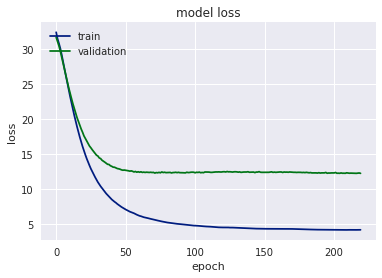

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

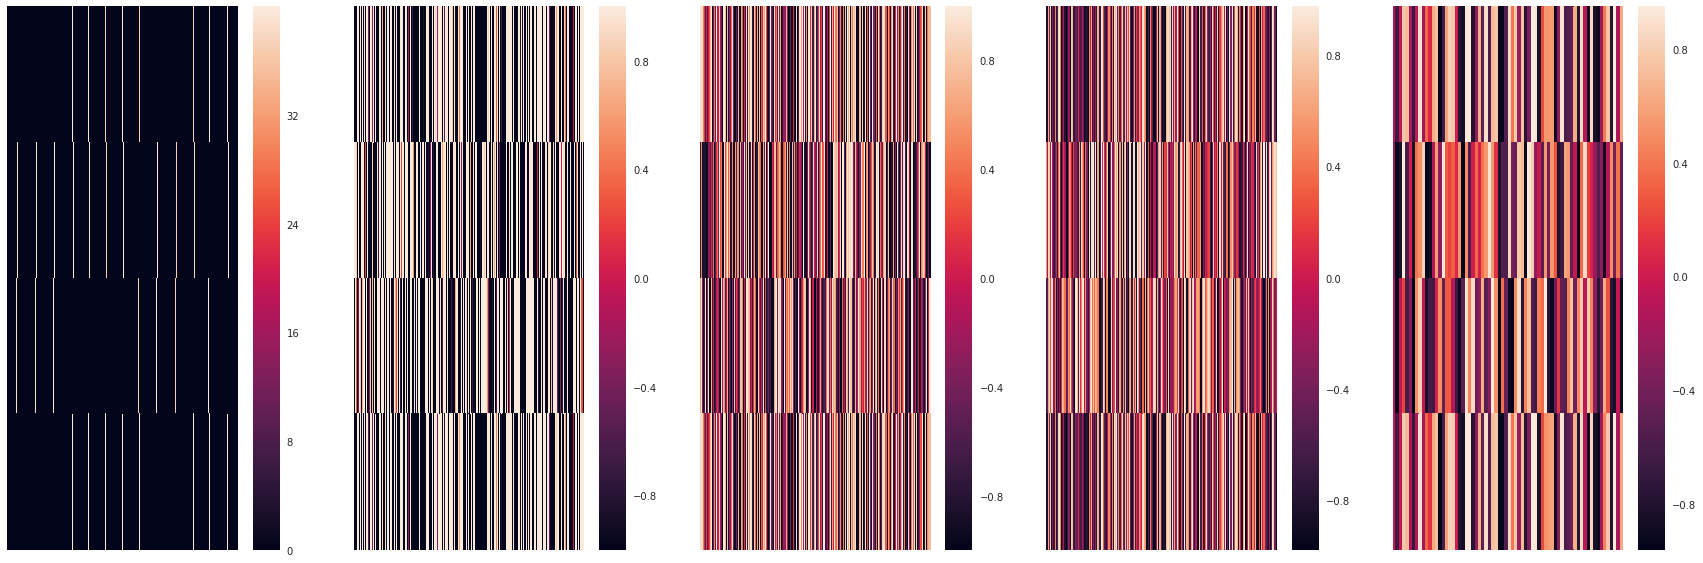

In [16]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, sharey=True, figsize = (30,10))
sns.heatmap(xtest1[-4:], xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax1)
sns.heatmap(hidden_1.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax2)
sns.heatmap(hidden_2.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax3)
sns.heatmap(hidden_3.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax4)
sns.heatmap(encoder.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax5)
plt.show()

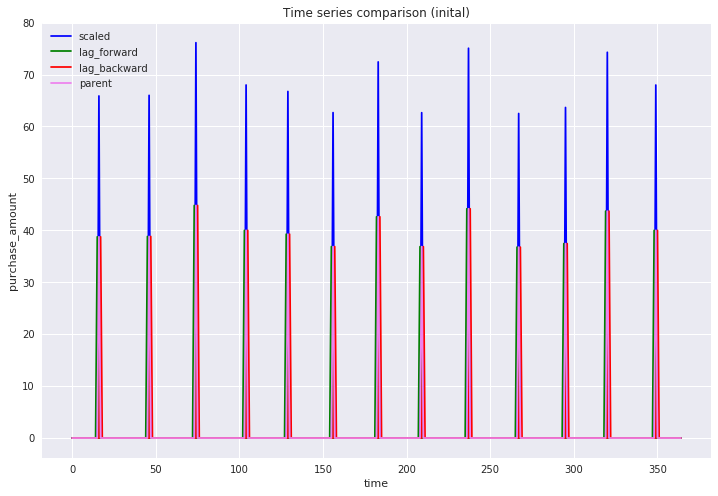

In [17]:
plt.figure(figsize = (12,8))
plt.plot(xtest1[-1], color = 'blue', label = 'scaled')
plt.plot(xtest1[-2], color = 'green', label = 'lag_forward')
plt.plot(xtest1[-3], color = 'red', label = 'lag_backward')
plt.plot(xtest1[-4], color = 'violet', label = 'parent')
plt.title('Time series comparison (inital)')
plt.legend(loc = 'best')
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

In [18]:
encoded_mat = encoder.predict(xtrain1)
encoded_mat_test = encoder.predict(xtest1)

decoded_mat = autoencoder.predict(xtrain1)
decoded_mat_test = autoencoder.predict(xtest1)

/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


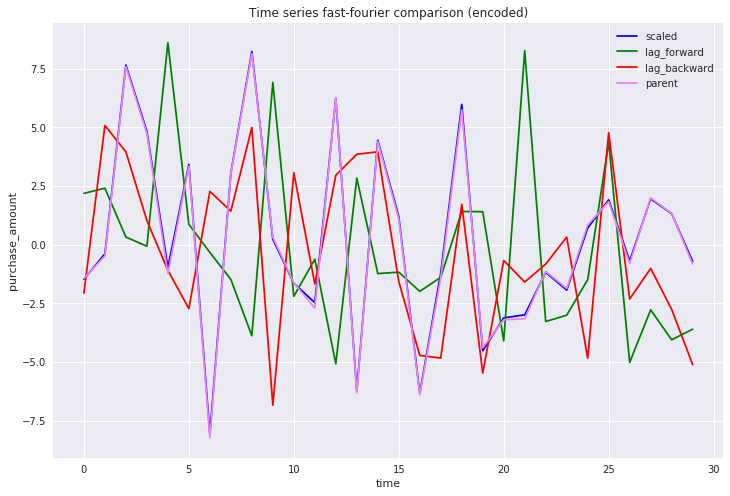

In [19]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fft(encoded_mat_test[-1])[-30:], color = 'blue', label = 'scaled')
plt.plot(np.fft.fft(encoded_mat_test[-2])[-30:], color = 'green', label = 'lag_forward')
plt.plot(np.fft.fft(encoded_mat_test[-3])[-30:], color = 'red', label = 'lag_backward')
plt.plot(np.fft.fft(encoded_mat_test[-4])[-30:], color = 'violet', label = 'parent')
plt.title('Time series fast-fourier comparison (encoded)')
plt.legend(loc='best')
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

In [20]:
encoded_df = pd.DataFrame(encoded_mat)
encoded_df.insert(loc=0, column='id', value=df.columns[:5000].values)
encoded_df = encoded_df.set_index(encoded_df.id).drop(labels = ['id'], axis = 1)
encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,0.146152,0.732743,0.036341,-0.684087,0.625762,-0.954065,0.943747,0.634116,0.928303,0.716471,-0.776641,-0.439238,-0.745570,-0.721750,-0.286976,0.879224,-0.063166,0.114522,0.010775,-0.503971,-0.349273,0.820985,-0.447968,-0.575001,0.713133,0.718388,-0.912328,0.157713,0.737211,0.947977,-0.895590,0.234746,-0.118922,-0.838018,0.072670,0.435507,0.681236,-0.105497,0.520368,-0.191843,0.804275,0.390902,0.987720,0.837365,-0.929356,0.573974,-0.841266,0.979365,0.851607,-0.411165,-0.809371,0.497404,0.325914,0.268840,-0.839608,-0.765539,0.761169,-0.882803,0.299836,0.804625,0.359317,0.086988,-0.897428,-0.308617,-0.178798,0.815604,-0.912533,-0.651539,0.306866,0.187732
Donor_100,-0.634214,-0.745882,0.621931,-0.342750,-0.680708,-0.151955,-0.657966,-0.493213,0.845623,0.285407,0.375955,0.662362,-0.249502,0.812832,-0.419135,-0.863575,0.635738,-0.880766,-0.613625,-0.513018,-0.197575,-0.988869,-0.116935,0.607697,0.792888,-0.846970,-0.836875,0.358246,-0.124664,-0.758774,0.301171,-0.056559,0.795257,-0.281035,0.481178,0.362760,0.464947,0.208139,0.153508,-0.575127,-0.591782,0.246526,0.665284,-0.352255,-0.441829,-0.477222,0.834134,0.857297,0.952431,-0.846093,-0.401478,0.867117,0.481291,0.867745,0.143062,-0.855865,0.837413,-0.970513,-0.403537,-0.633432,-0.070777,0.212588,0.740245,0.464101,0.599683,-0.785449,-0.120966,0.666385,0.514155,-0.971680
Donor_1000,-0.329409,-0.619856,0.637960,-0.906901,-0.115663,-0.741950,-0.993630,0.084624,-0.643757,0.578240,0.047180,0.472976,0.452784,0.301872,0.539675,0.612636,-0.304277,-0.452444,0.697869,0.761907,0.632361,-0.876451,0.284769,0.816442,0.542623,0.720039,-0.542866,0.915888,0.446537,0.537366,0.561704,0.069869,-0.128716,0.759870,0.696897,0.763977,0.405302,-0.087561,-0.157833,0.071794,-0.749662,0.600249,0.629843,0.959669,0.844700,-0.704473,-0.102853,-0.417281,-0.414371,-0.741063,0.909312,-0.846625,0.256907,0.678440,0.369591,-0.082501,0.249375,-0.906874,0.699587,0.518369,0.165477,-0.904433,0.803879,-0.797452,0.688439,-0.808500,-0.766674,-0.543163,-0.597126,-0.689796
Donor_1001,0.940471,-0.869629,-0.872105,-0.257981,-0.922398,0.769163,0.727991,0.341145,-0.842455,-0.736324,-0.887702,0.262989,-0.715983,0.987028,0.469756,-0.893566,-0.440487,-0.416308,0.439311,0.515635,0.161623,0.238749,0.674169,-0.435946,-0.896588,-0.558101,0.957423,0.972352,0.869483,0.778397,0.456302,0.870883,0.618653,0.173224,-0.624460,0.387569,0.303724,0.817084,-0.354863,-0.851916,-0.518206,0.762253,-0.596055,0.387960,-0.657905,-0.838623,0.601237,-0.094182,0.351146,-0.303772,0.654860,0.957566,0.461684,0.977125,0.739916,0.387348,0.606484,0.150094,-0.830312,0.098055,-0.772972,-0.847510,0.789123,0.932744,0.116200,-0.899725,-0.855727,0.889701,0.528561,-0.575235
Donor_1002,-0.864390,0.606514,0.898194,0.868784,0.730348,-0.828244,-0.061924,0.260179,0.847606,-0.833272,0.771873,0.239739,-0.721819,0.411313,-0.904186,-0.032065,0.230860,0.171452,-0.074367,0.425944,0.241140,0.074800,0.791677,0.872553,0.535741,-0.246944,-0.479737,0.573946,-0.062349,-0.370686,0.842493,-0.973532,0.309927,-0.767019,-0.073173,0.990180,-0.848273,0.511469,-0.132752,0.639314,0.813035,-0.830934,-0.731900,-0.241062,0.964838,0.189114,-0.324384,-0.190108,-0.924039,-0.601782,-0.218703,-0.406660,-0.446919,0.081694,0.885597,-0.599707,0.621557,0.422437,0.571458,-0.863604,-0.645523,0.898668,-0.688254,-0.712005,-0.311970,-0.478630,-0.339394,-0.585647,0.935516,-0.654707


In [21]:
encoded_df_test = pd.DataFrame(encoded_mat_test)
encoded_df_test.insert(loc=0, column='id', value=df.columns[5000:].values)
encoded_df_test = encoded_df_test.set_index(encoded_df_test.id).drop(labels = ['id'], axis = 1)
encoded_df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,0.487115,0.923987,-0.784021,-0.920115,0.840317,0.654729,0.051876,-0.936528,-0.127978,-0.193744,-0.257126,0.290562,-0.225755,0.731896,-0.178537,0.920867,0.937173,0.612450,-0.836721,0.574029,0.294002,0.199366,-0.885539,0.827889,-0.552788,0.258032,0.886166,-0.082195,-0.513270,0.834863,0.427327,-0.651450,0.750006,0.866158,0.776322,-0.696466,0.857022,-0.465958,0.912781,0.935505,-0.613022,-0.047130,0.797417,-0.931308,-0.628163,-0.899965,-0.269089,0.542763,0.978594,-0.483117,-0.997558,0.654217,0.765409,-0.869835,0.570788,-0.875520,-0.504315,0.540706,-0.815800,-0.449800,-0.236732,0.361481,0.179001,0.691129,0.532725,-0.702972,0.027178,0.762421,-0.843885,-0.338593
Test_145,0.690174,-0.851060,-0.943096,-0.842535,0.760786,-0.096203,0.097734,-0.529791,-0.957018,0.584694,-0.958181,-0.455627,0.143991,0.947036,-0.558910,-0.742806,0.720235,-0.493021,-0.701969,0.448541,0.198221,-0.654364,0.244358,0.439506,0.306846,-0.298810,0.799757,0.614446,0.405659,0.995684,0.880885,0.831943,0.489285,-0.542580,-0.896175,0.457638,-0.005103,0.242791,-0.402420,-0.887589,0.017753,0.625244,-0.777588,-0.844589,0.376194,-0.834433,0.895119,-0.797290,0.618830,0.613253,-0.970068,0.244189,-0.809820,0.454011,-0.054288,-0.626604,-0.243600,0.875044,-0.010814,0.659341,-0.892985,-0.817615,-0.513450,-0.226539,-0.677321,0.643871,-0.821684,0.451429,0.392362,-0.243551
Test_1450,0.082780,-0.919683,-0.813272,0.400610,0.462615,0.478666,-0.207106,0.754638,-0.075431,-0.799729,0.813997,-0.978570,0.545135,-0.712259,-0.740146,0.638451,-0.078668,-0.381779,0.817948,0.794283,-0.435681,0.455067,0.938312,0.395214,-0.108378,0.598497,-0.750851,0.531883,-0.868396,0.099884,0.474881,0.637047,-0.605991,0.892526,-0.109711,0.758713,0.752463,-0.920004,0.780300,0.465707,-0.254473,0.830277,-0.867710,0.987218,-0.122769,0.783391,-0.577485,0.771355,-0.483834,0.477207,-0.737065,-0.805617,-0.024108,-0.601086,-0.622685,0.704148,-0.285892,-0.837201,0.561304,-0.705505,0.367956,-0.677260,-0.321854,-0.395032,-0.200296,-0.622099,0.906684,-0.188931,-0.711888,0.749836
Test_1451,-0.355415,-0.967337,0.067845,-0.873381,0.161452,0.263439,0.383328,-0.857200,-0.671099,-0.947554,0.378387,0.296681,-0.232202,-0.925718,0.697199,0.582382,0.323031,-0.034101,-0.173769,0.963776,-0.176195,0.906759,-0.721897,0.773116,-0.534638,-0.088835,-0.374968,0.580994,-0.791761,-0.563774,-0.330458,0.832471,-0.621353,0.610494,0.686394,-0.617587,0.818910,0.403004,-0.450053,0.256337,0.777859,-0.920152,-0.751937,0.214316,-0.752523,-0.573579,0.800260,0.910831,0.375814,-0.490181,-0.148752,-0.949520,-0.838456,-0.825215,-0.649201,-0.915968,-0.628461,0.263640,-0.170617,-0.495348,0.553852,-0.068903,-0.956235,-0.972818,-0.553060,-0.259379,0.917957,-0.702602,0.178180,0.053902
Test_1452,-0.116655,-0.189210,-0.017556,0.037225,-0.888258,0.156005,0.237542,0.949232,-0.899604,0.661121,0.802899,0.918284,-0.910888,-0.741751,0.408661,-0.946043,-0.014452,0.444574,0.905882,0.212336,-0.538369,0.737823,-0.650134,-0.645469,-0.637085,-0.483970,0.960191,0.779572,0.421049,0.013599,-0.348782,0.601921,-0.491406,-0.740232,0.428959,-0.988839,-0.545739,0.947553,-0.780813,-0.514609,-0.949936,-0.919915,-0.613721,-0.617233,-0.216336,-0.820437,0.948349,-0.871081,0.263755,-0.871097,-0.593585,-0.178129,-0.766897,-0.210600,0.024246,-0.701995,0.891124,0.909796,-0.901520,0.027863,0.425821,-0.634515,-0.016882,0.941964,-0.513142,0.114300,-0.630435,0.455344,-0.308199,-0.053808


In [22]:
xtrain = pd.DataFrame(xtrain1)
average_initial = xtrain.mean(axis = 0)
xtrain.insert(loc = 0, column = 'id', value = df.columns[:5000].values)
xtrain = xtrain.set_index(xtrain.id).drop(labels = ['id'], axis = 1)
xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,0.0,0.0,0.0,0.0,0.0,0.0,28.103086,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,25.465567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,29.395883,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.681370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,28.54345,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,28.002926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,27.025801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.822557,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,30.611507,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.675734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.815237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.406283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,29.19701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,32.555135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Donor_100,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,15.523447,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,21.602001,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.930828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,

In [23]:
comparison = pd.DataFrame(decoded_mat)
average_decoded = comparison.mean(axis = 0)
comparison.insert(loc = 0, column = 'id', value = df.columns[:5000].values)
comparison = comparison.set_index(comparison.id).drop(labels = ['id'], axis = 1)
comparison.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,0.0,0.0,0.000000,0.0,0.0,0.0,29.506741,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,36.887741,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,28.021114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,24.223089,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.173702,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,31.165894,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.701738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.888153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,27.468662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,33.169235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Donor_100,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,21.780806,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.041798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,22.176517

In [24]:
xtest = pd.DataFrame(xtest1)
average_initial_test = xtest.mean(axis = 0)
xtest.insert(loc = 0, column = 'id', value = df.columns[5000:].values)
xtest = xtest.set_index(xtest.id).drop(labels = ['id'], axis = 1)
xtest.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,34.0962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,27.922484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,32.689643,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,32.538395,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,31.536311,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,31.296507,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,32.473824,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,25.174308,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,27.997594,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,32.697277,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,33.582588,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.953825,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.773184,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.259073
Test_145,0.0,0.0,43.088934,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,43.384996,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,40.449101,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.

In [25]:
comparison_test = pd.DataFrame(decoded_mat_test)
average_decoded_test = comparison_test.mean(axis = 0)
comparison_test.insert(loc = 0, column = 'id', value = df.columns[5000:].values)
comparison_test = comparison_test.set_index(comparison_test.id).drop(labels = ['id'], axis = 1)
comparison_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,24.873156,0.0,0.0,0.0,1.063072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.045408,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,14.439565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,14.764951,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,10.433189,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,49.839458,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,41.643665,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,21.38294,0.0,14.299236,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,36.47916,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,2.21017,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.178557,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,31.733566,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,8.963736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.642021,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.277906,24.368681,0.0,0.0,6.209806,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.893749
Test_145,0.0,0.0,2.765056,0.0,0.0,0.0,0.0,29.960705,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,13.832976,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.583456,0.0,30.276871,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000

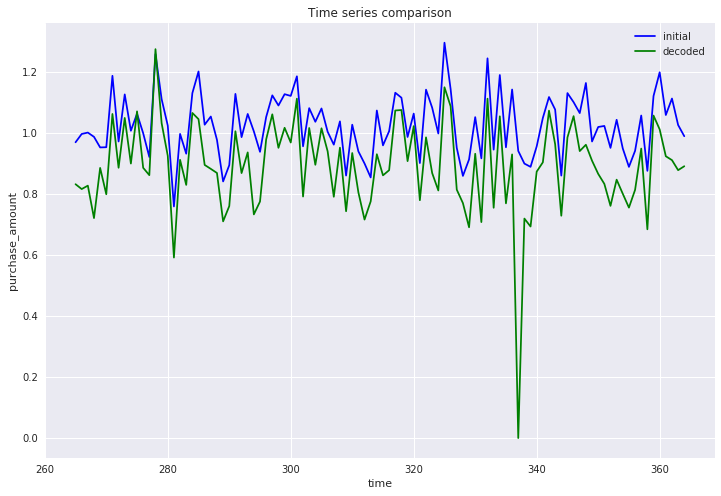

In [26]:
plt.figure(figsize = (12,8))
plt.plot(average_initial[-100:], color = 'blue', label = 'initial')
plt.plot(average_decoded[-100:], color = 'green', label = 'decoded')
plt.title('Time series comparison')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


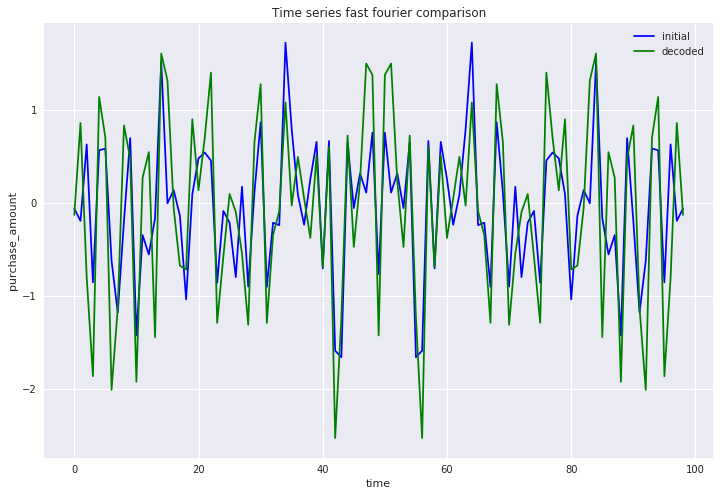

In [27]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fft(average_initial[-100:])[1:], color = 'blue', label = 'initial')
plt.plot(np.fft.fft(average_decoded[-100:])[1:], color = 'green', label = 'decoded')
plt.title('Time series fast fourier comparison')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

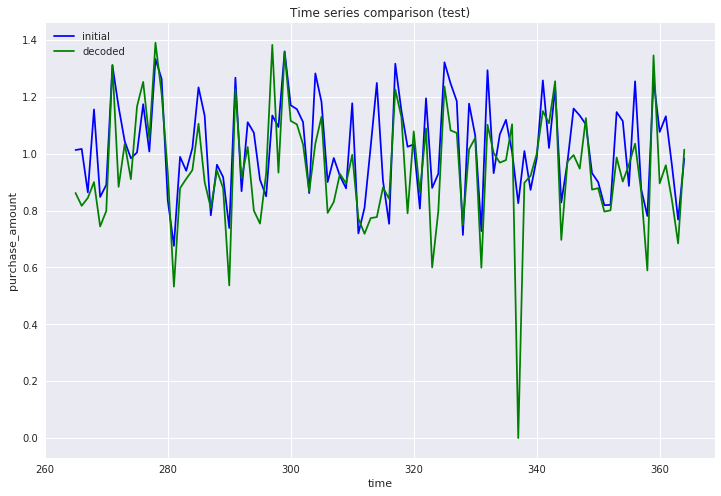

In [28]:
plt.figure(figsize = (12,8))
plt.plot(average_initial_test[-100:], color = 'blue', label = 'initial')
plt.plot(average_decoded_test[-100:], color = 'green', label = 'decoded')
plt.title('Time series comparison (test)')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


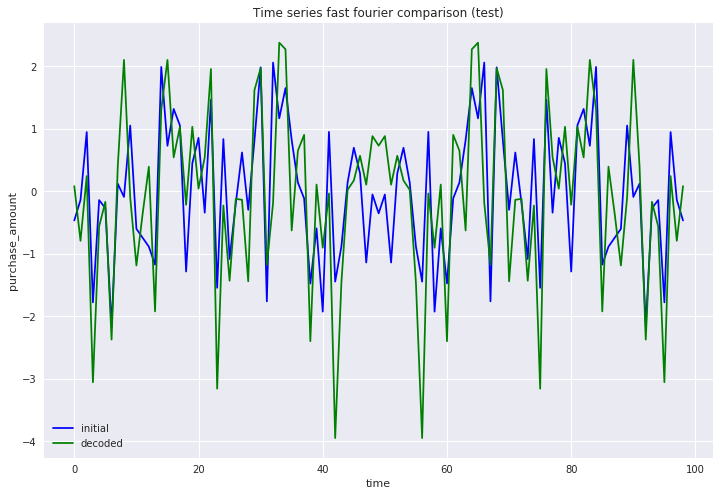

In [29]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fft(average_initial_test[-100:])[1:], color = 'blue', label = 'initial')
plt.plot(np.fft.fft(average_decoded_test[-100:])[1:], color = 'green', label = 'decoded')
plt.title('Time series fast fourier comparison (test)')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

In [30]:
binary_xtrain = np.where(xtrain>0, 1, 0)
binary_decoded_mat = np.where(decoded_mat>0,1,0)

binary_xtest = np.where(xtest>0, 1, 0)
binary_decoded_mat_test = np.where(decoded_mat_test>0,1,0)

In [31]:
print('Percent similarity', 100 - (abs(np.linalg.norm(xtrain)-np.linalg.norm(decoded_mat))*100/min(np.linalg.norm(xtrain), np.linalg.norm(decoded_mat))))
print('Percent similarity binary', 100 - (abs(np.linalg.norm(binary_xtrain)-np.linalg.norm(binary_decoded_mat))*100/min(np.linalg.norm(binary_xtrain), np.linalg.norm(binary_decoded_mat))))

Percent similarity 92.78139237915124
Percent similarity binary 97.89142802800865


In [32]:
print('Percent similarity', 100 - (abs(np.linalg.norm(xtest)-np.linalg.norm(decoded_mat_test))*100/min(np.linalg.norm(xtest), np.linalg.norm(decoded_mat_test))))
print('Percent similarity binary', 100 - (abs(np.linalg.norm(binary_xtest)-np.linalg.norm(binary_decoded_mat_test))*100/min(np.linalg.norm(binary_xtest), np.linalg.norm(binary_decoded_mat_test))))

Percent similarity 96.80067204513898
Percent similarity binary 88.4658440418738


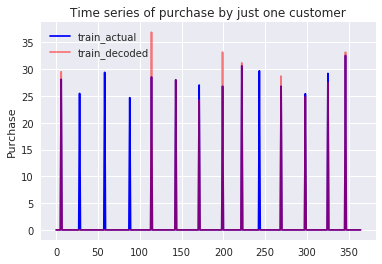

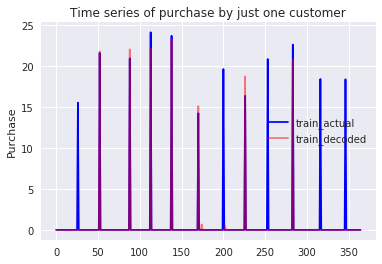

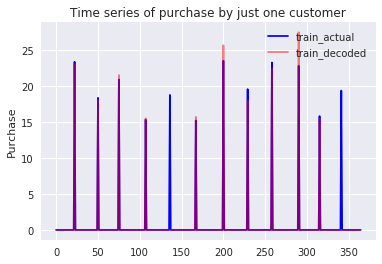

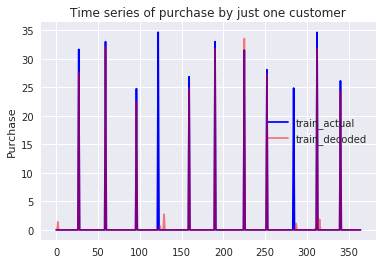

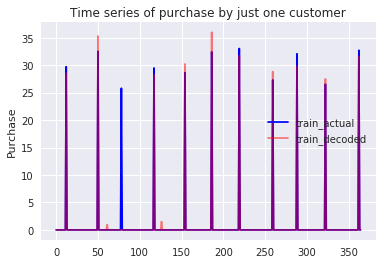

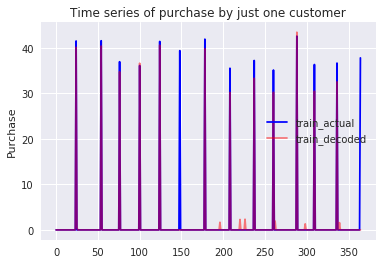

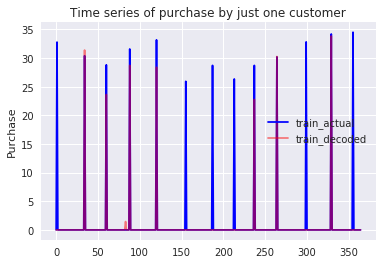

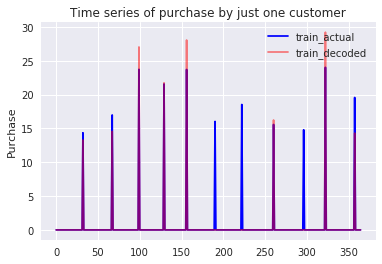

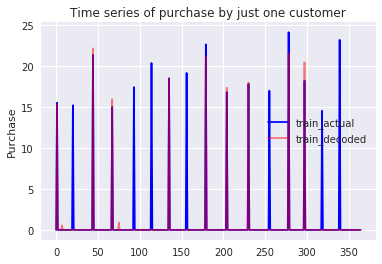

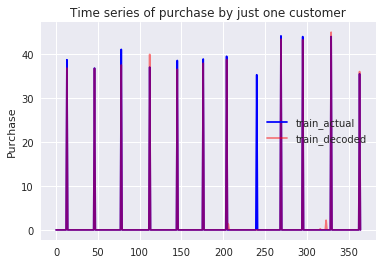

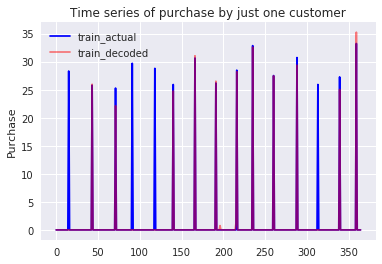

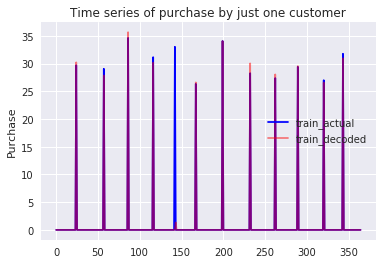

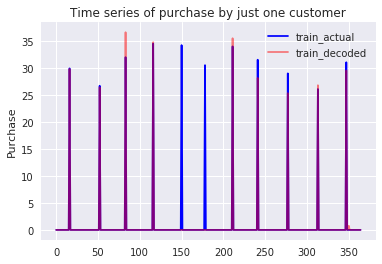

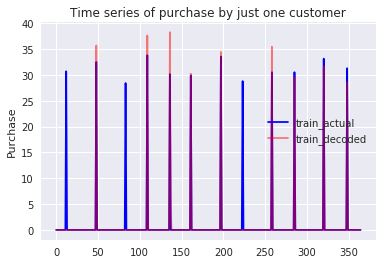

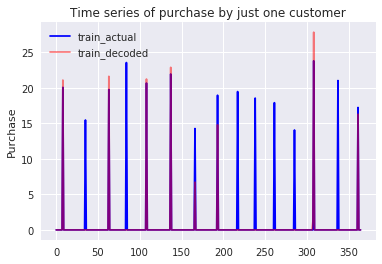

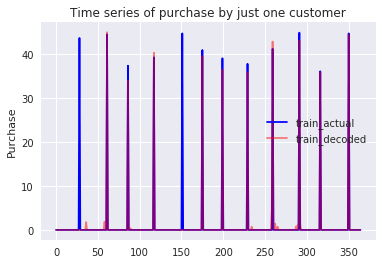

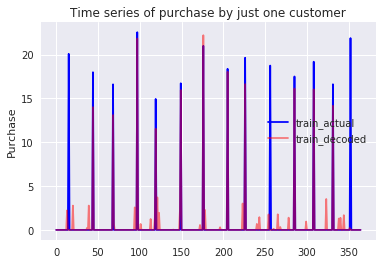

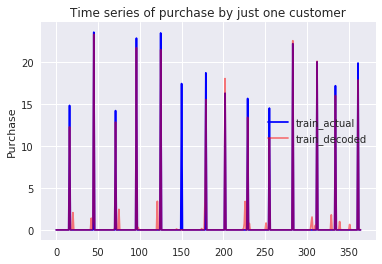

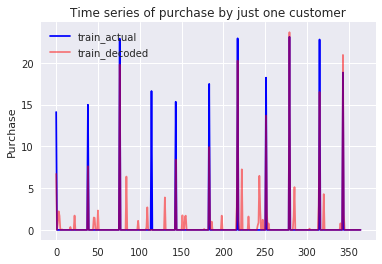

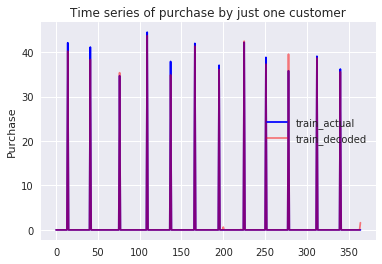

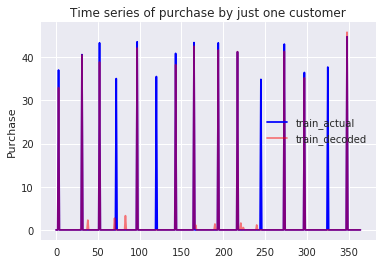

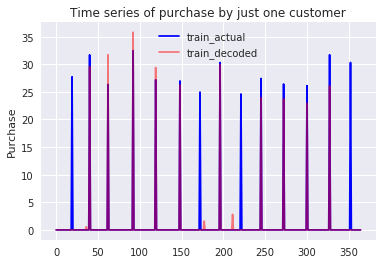

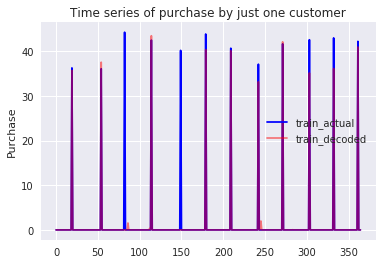

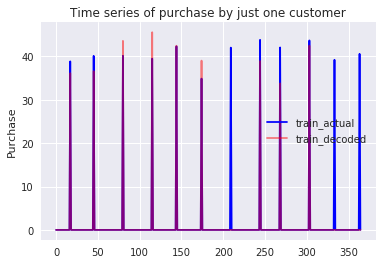

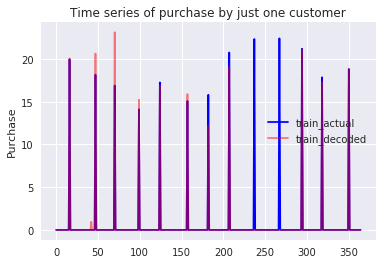

In [33]:
for i in list(xtrain.index[:25]):
    plt.title('Time series of purchase by just one customer')
    plt.plot(xtrain.loc[i,:], color = 'blue', label = 'train_actual')
    plt.plot(comparison.loc[i,:], color = 'red', label = 'train_decoded', alpha=0.5)
    plt.legend(loc='best')
    plt.ylabel('Purchase')
    plt.show()